In [1]:
# 引入库

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()

import datetime
from scipy.stats import norm
import scipy as sp
import statsmodels.api as sm

%matplotlib inline
import xlrd

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("./input/train.csv", parse_dates=['timestamp'])
test = pd.read_csv("./input/test.csv", parse_dates=['timestamp'])
macro = pd.read_csv("./input/macro.csv", parse_dates=['timestamp'])
id_test = test.id

fx = pd.read_excel('./input/BAD_ADDRESS_FIX.xlsx').drop_duplicates('id').set_index('id')
train.update(fx)
test.update(fx)

In [3]:
macro.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,brent,net_capital_export,gdp_annual,gdp_annual_growth,average_provision_of_build_contract,average_provision_of_build_contract_moscow,rts,micex,micex_rgbi_tr,micex_cbi_tr,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,grp,grp_growth,income_per_cap,real_dispos_income_per_cap_growth,salary,salary_growth,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,retail_trade_turnover_growth,labor_force,unemployment,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,share_own_revenues,overdue_wages_per_cap,fin_res_per_cap,marriages_per_1000_cap,divorce_rate,construction_value,invest_fixed_assets_phys,pop_natural_increase,pop_migration,pop_total_inc,childbirth,mortality,housing_fund_sqm,lodging_sqm_per_cap,water_pipes_share,baths_share,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,rent_price_4+room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,load_of_teachers_preschool_per_teacher,child_on_acc_pre_school,load_of_teachers_school_per_teacher,students_state_oneshift,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,provision_retail_space_sqm,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.2,-0.078209,5.0,NaN,NaN,NaN,NaN,NaN,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,63932.0,732.760604,0.716,0.284,0.962915,12865.0,233.351529,8.0,3.9,553874.9,95.8,-0.3,14.1,13.8,10.7,11.0,216.0,18.715883,99.9,99.8,99.6,44.4,95.7,55.0,99.9,0.3,74.2,6.1,5.87,696.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.0,99.4,7872.848285,162.9,NaN,NaN,NaN,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.2,-0.078209,5.0,NaN,NaN,NaN,NaN,175.15,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,63932.0,732.760604,0.716,0.284,0.962915,12865.0,233.351529,8.0,3.9,553874.9,95.8,-0.3,14.1,13.8,10.7,11.0,216.0,18.715883,99.9,99.8,99.6,44.4,95.7,55.0,99.9,0.3,74.2,6.1,5.87,696.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.0,99.4,7872.848285,162.9,NaN,NaN,NaN,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.2,-0.078209,5.0,NaN,NaN,NaN,NaN,178.66,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,63932.0,732.760604,0.716,0.284,0.962915,12865.0,233.351529,8.0,3.9,553874.9,95.8,-0.3,14.1,13.8,10.7,11.0,216.0,18.715883,99.9,99.8,99.6,44.4,95.7,55.0,99.9,0.3,74.2,6.1,5.87,696.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.0,99.4,7872.848285,162.9,NaN,NaN,NaN,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,43.4054,80.12,NaN,38807.2,-0.078209,5.0,NaN,NaN,NaN,NaN,183.44,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,63932.0,732.760604,0.716,0.284,0.962915,12865.0,233.351529,8.0,3.9,553874.9,95.8,-0.3,14.1,13.8,10.7,11.0,216.0,18.715883,99.

In [4]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [5]:
data = pd.DataFrame(train, columns = ['timestamp', 'price_doc'])
grouped_df = data.groupby('timestamp')['price_doc'].aggregate(np.median).reset_index()
macro = pd.merge(macro, grouped_df, on='timestamp')

In [6]:
dtype_df = macro.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,datetime64[ns],1
1,int64,2
2,float64,95
3,object,3


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


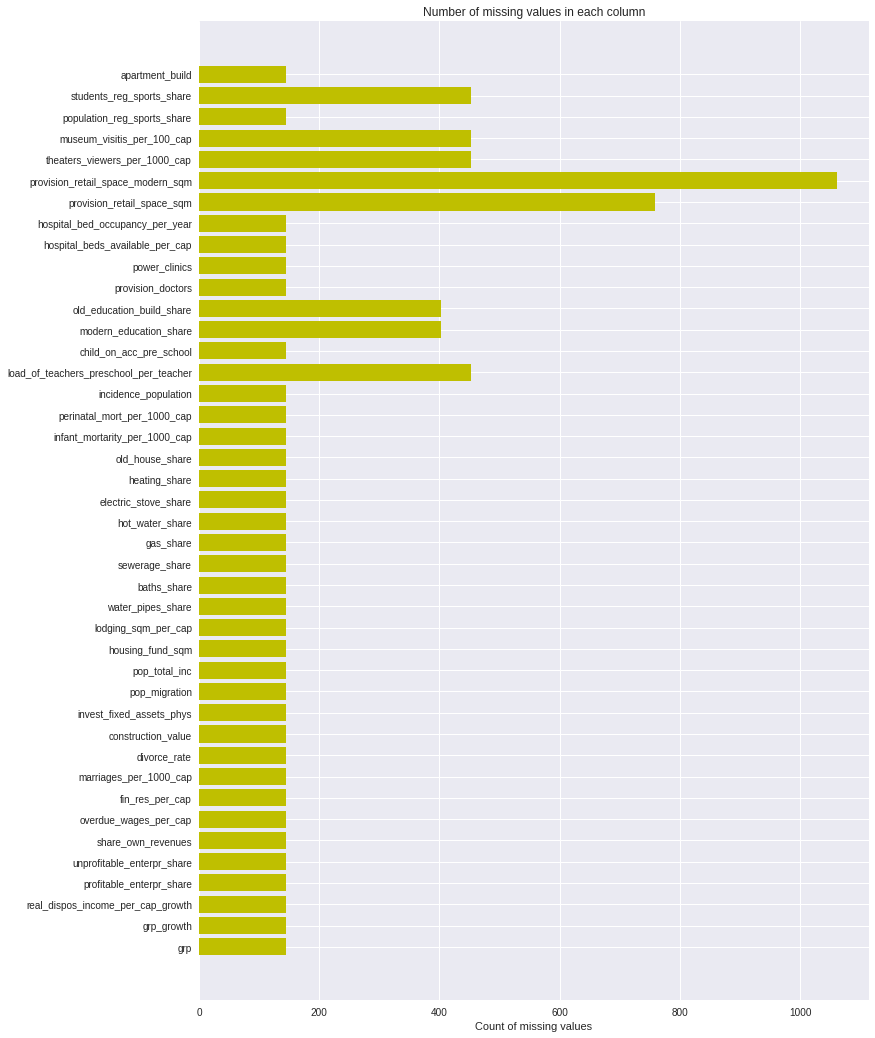

In [7]:
missing_df = macro.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

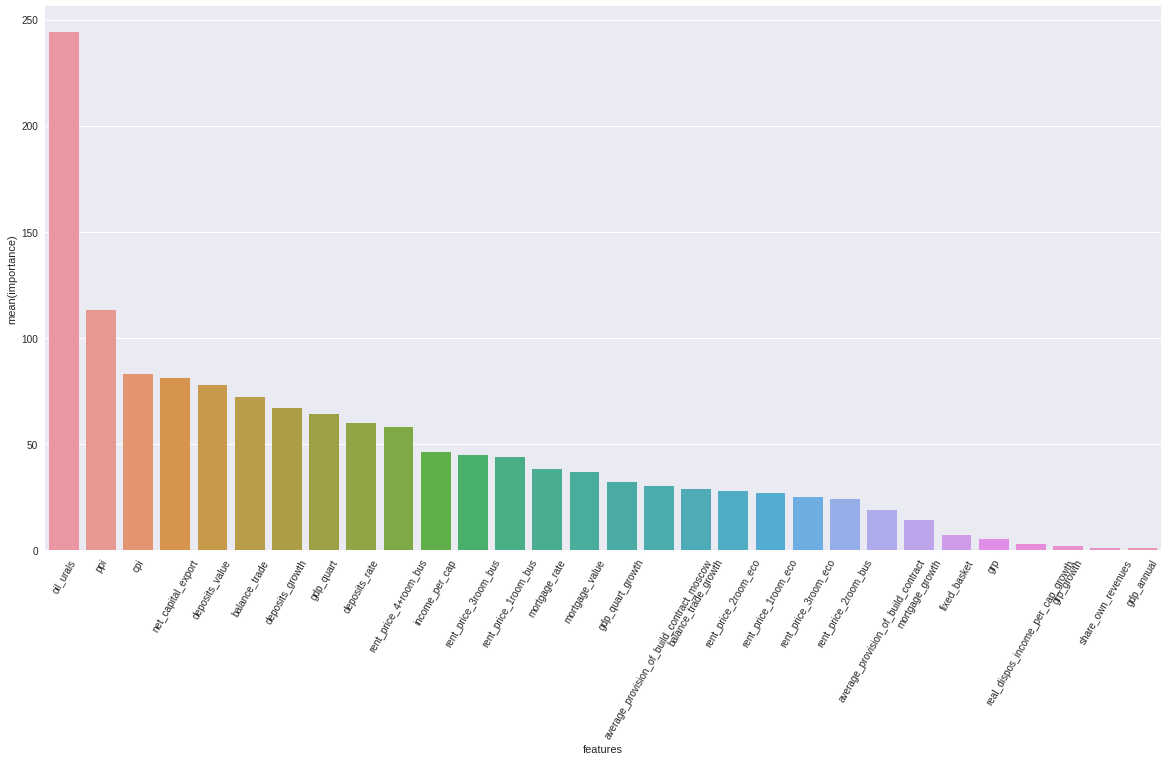

In [8]:
for f in macro.columns:
    if macro[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(macro[f].values)) 
        macro[f] = lbl.transform(list(macro[f].values))
        
train_y = macro.price_doc.values
train_X = macro.drop(["timestamp", "price_doc",
                      "usdrub", "eurrub", "brent", "rts", "micex", "micex_rgbi_tr", "micex_cbi_tr"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# plot the important features #
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=60)
sns.barplot(data=features.head(30),x="features",y="importance",ax=ax,orient="v")

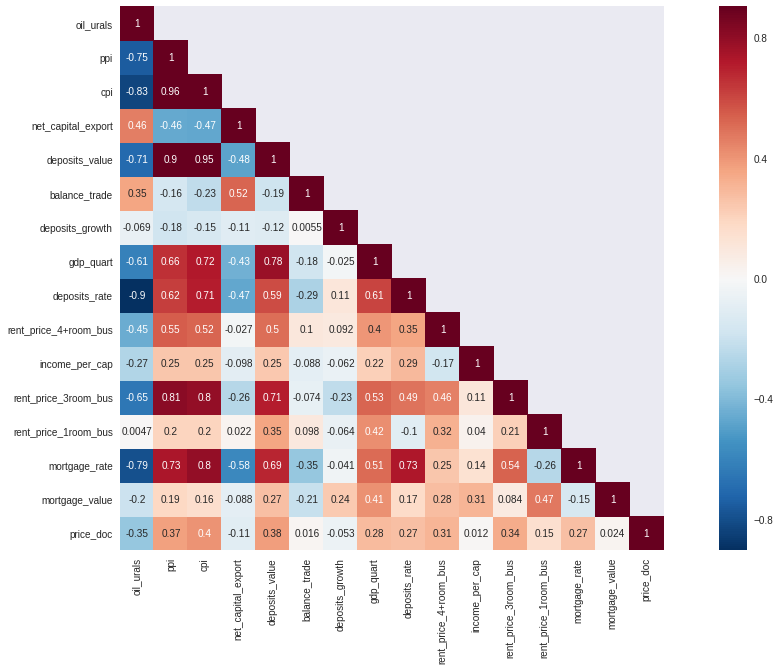

In [9]:
topFeatures = features["features"].tolist()[:15]
topFeatures.append("price_doc")
corrMatt = macro[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

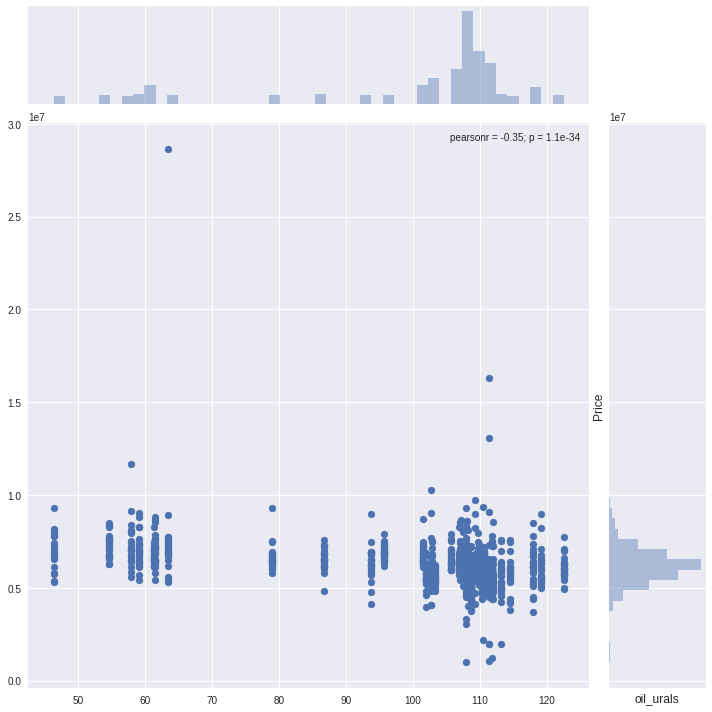

In [10]:
plt.figure(figsize=(12,12))
sns.jointplot(macro.oil_urals.values, macro.price_doc.values, size=10)
plt.ylabel('Price', fontsize=12)
plt.xlabel('oil_urals', fontsize=12)
plt.show()

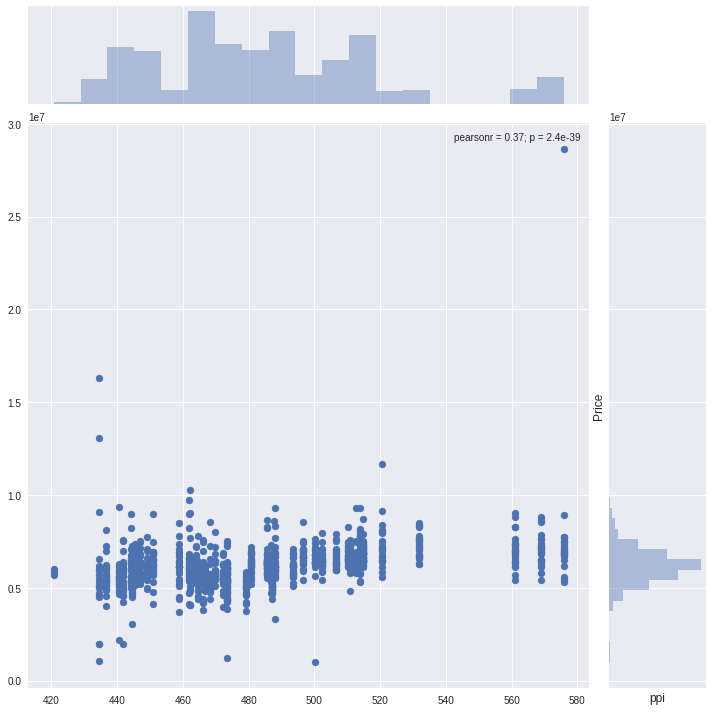

In [11]:
plt.figure(figsize=(12,12))
sns.jointplot(macro.ppi.values, macro.price_doc.values, size=10)
plt.ylabel('Price', fontsize=12)
plt.xlabel('ppi', fontsize=12)
plt.show()

In [12]:
macro = pd.read_csv("./input/macro.csv")
macro['yearmonth'] = macro['timestamp'].apply(lambda x: x[:4] + "-" + x[5:7])
macro['year'] = macro['timestamp'].apply(lambda x: x[:4])
macro['month'] = macro['timestamp'].apply(lambda x: x[5:7])
macro.drop(['timestamp'], axis=1)
macro_grouped = macro.groupby('yearmonth').aggregate(np.median).reset_index()

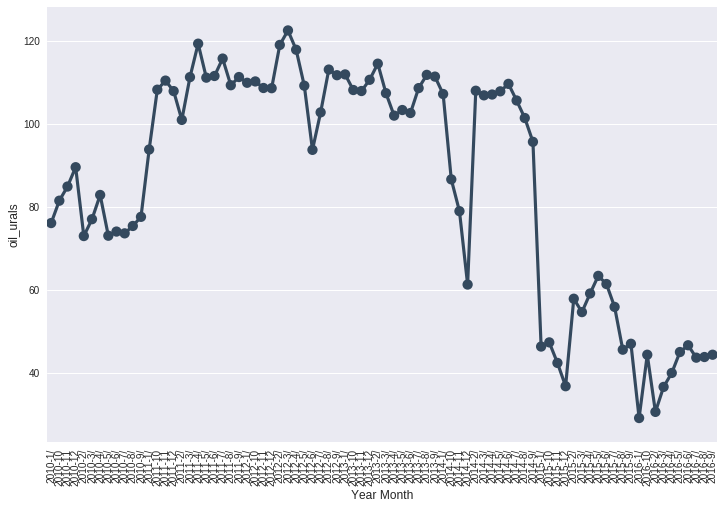

In [13]:
plt.figure(figsize=(12,8))
sns.pointplot(macro_grouped.yearmonth.values, macro_grouped.oil_urals.values, alpha=0.8, color="#34495e")
plt.ylabel('oil_urals', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

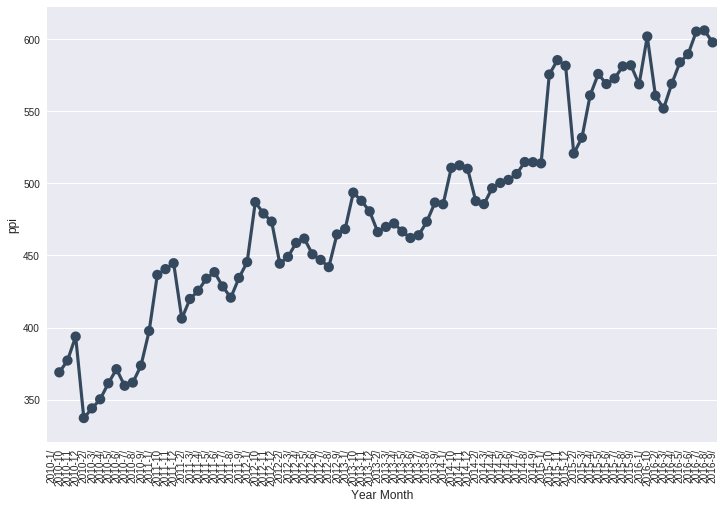

In [14]:
plt.figure(figsize=(12,8))
sns.pointplot(macro_grouped.yearmonth.values, macro_grouped.ppi.values, alpha=0.8, color="#34495e")
plt.ylabel('ppi', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

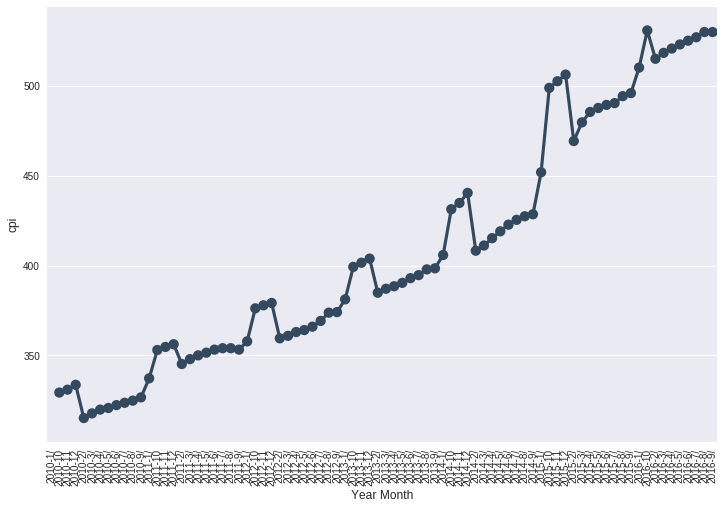

In [15]:
plt.figure(figsize=(12,8))
sns.pointplot(macro_grouped.yearmonth.values, macro_grouped.cpi.values, alpha=0.8, color="#34495e")
plt.ylabel('cpi', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

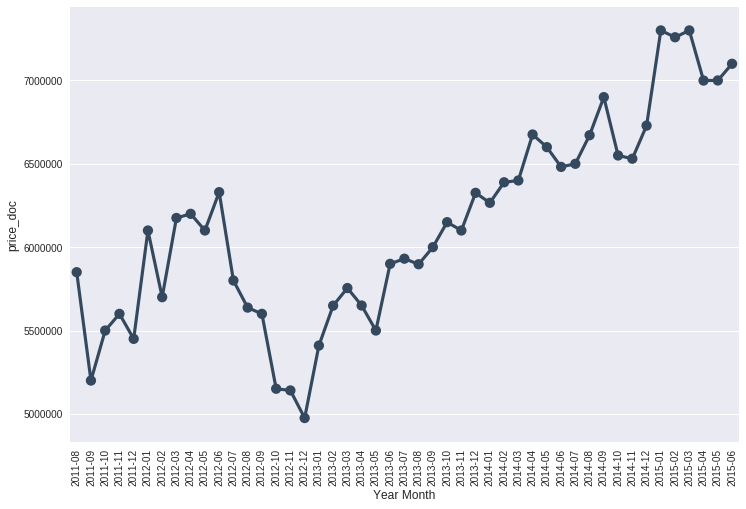

In [16]:
train = pd.read_csv("./input/train.csv")
train['yearmonth'] = train['timestamp'].apply(lambda x: x[:4] + "-" + x[5:7])
train['year'] = train['timestamp'].apply(lambda x: x[:4])
train['month'] = train['timestamp'].apply(lambda x: x[5:7])

data = pd.DataFrame(train, columns = ['yearmonth', 'year', 'month', 'price_doc'])
grouped_df = data.groupby('yearmonth').aggregate(np.median).reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df.yearmonth.values, grouped_df.price_doc.values, alpha=0.8, color="#34495e")
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()